# Machine Translation and Data Sets

Machine translation (MT) refers to the automatic translation of a segment of text from one language to another. Solving this problem with neural networks is often called neural machine translation (NMT).Compared to the language model we discussed before, a major difference for MT is that the output is a sequence of words instead of a single words. The length of the output sequence could be different to the source sequence length. In the rest of this section, we will demonstrate how to pre-process a MT dataset and transform it into a set of data batches.

In [1]:
import sys
sys.path.insert(0, '..')
import collections
import d2l
import zipfile
from d2l.data.base import Vocab

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

## Read and Pre-process Data

We first download a dataset that contains a set of English sentences with the corresponding French trans-
lations. As can be seen that each line contains a English sentence with its French translation, which are
separated by a TAB.

In [2]:
!wget -c http://www.manythings.org/anki/fra-eng.zip
with zipfile.ZipFile('fra-eng.zip', 'r') as f:
  raw_text = f.read('fra.txt').decode("utf-8")

--2019-06-10 12:39:52--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3423204 (3.3M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   3.26M  2.06MB/s    in 1.6s    

2019-06-10 12:39:54 (2.06 MB/s) - ‘fra-eng.zip’ saved [3423204/3423204]



In [3]:
print(raw_text[0:95])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!


Words and punctuation marks should be separated by spaces. But this dataset has a few exceptions. We
fix them by adding necessary spaces before punctuation marks, replacing non-breaking space with space. In
addition, we convert all chars into lower cases.

In [4]:
def preprocess_raw(text):
  text = text.replace('\u202f', ' ').replace('\xa0', ' ')
  out = ''
  for i, char in enumerate(text.lower()):
    if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
      out += ' '
    out += char
  return out

text = preprocess_raw(raw_text)
print(text[0:95])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who?	qui ?
wow !	ça alors !
fire !	au feu !


## Tokenization

A word or a punctuation mark is treated as a token, then a sentence is a list of tokens. We convert the text
data into a set of source (English) sentences, a list of list of tokens, and a set of target (French) sentences.
To simplify the later model training, we only sample the first num_examples sentences pairs.

In [5]:
num_examples = 50000
source, target = [], []
for i, line in enumerate(text.split('\n')):
  if i > num_examples:
    break
  parts = line.split('\t')
  if len(parts) == 2:
    source.append(parts[0].split(' '))
    target.append(parts[1].split(' '))
    
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['cours', '!']])

We visualize the histogram of the number of tokens per sentence the following figure. As can be seen that a
sentence in average contains 5 tokens, and most of them have less than 10 tokens.

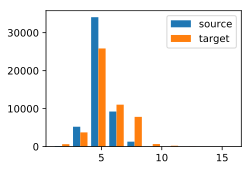

In [6]:
d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
d2l.plt.legend(loc='upper right');

## Vocabulary

Now build a vocabulary for the source sentences and print its vocabulary sizes.

In [7]:
def build_vocab(tokens):
  tokens = [token for line in tokens for token in line]
  return d2l.data.base.Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

3790

## Load Dataset

Since sentences have variable lengths, we define a pad function to trim or pad a sentence into a fixed length.

In [8]:
def pad(line, max_len, padding_token):
  if len(line) > max_len:
    return line[:max_len]
  return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0]], 10, src_vocab.pad)

[37, 4, 0, 0, 0, 0, 0, 0, 0, 0]

Now we can convert a list of sentences into an (num_example, max_len) index array. We also record the
length of each sentence without the padding tokens, called valid length. In addition, we add the special
"bos" and "eos" tokens to the target sentences so that our model will know the signals for starting
and ending predictin.

In [9]:
def build_array(lines, vocab, max_len, is_source):
  lines = [vocab[line] for line in lines]
  if not is_source:
    lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
  array = torch.tensor([pad(line, max_len, vocab.pad) for line in lines])
  valid_len = (array != vocab.pad).sum(1)
  return array, valid_len

Finally, we construct data iterators to read data batches from the source and target index arrays.

In [10]:
def load_data_nmt(batch_size, max_len): # This function is saved in d2l.
  src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
  src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
  tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
  train_data = data.TensorDataset(
    src_array, src_valid_len, tgt_array, tgt_valid_len)
  train_iter = data.DataLoader(train_data, batch_size, shuffle=True)
  return src_vocab, tgt_vocab, train_iter

Let’s read the first batch.

In [11]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, in train_iter:
  print('X =', X.type(torch.int32), '\nValid lengths for X =', X_valid_len,
        '\nY =', Y.type(torch.int32), '\nValid lengths for Y =', Y_valid_len)
  break

X = tensor([[   9, 3015,   65, 2812,    4,    0,    0,    0],
        [  17,  538,    3,    4,    0,    0,    0,    0]], dtype=torch.int32) 
Valid lengths for X = tensor([5, 4]) 
Y = tensor([[   1,   30, 3855,  315, 4402,    4,    2,    0],
        [   1,   31,  269, 2854,    4,    2,    0,    0]], dtype=torch.int32) 
Valid lengths for Y = tensor([7, 6])
